# Import Libraries

In [1]:
import os
import zipfile

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Download & Explore Dataset

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip

--2021-09-15 19:47:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M  29.9MB/s    in 6.4s    

2021-09-15 19:47:51 (29.9 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]



In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2021-09-15 19:47:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/tmp/rps-test-set.z 100%[===================>]  28.15M  53.6MB/s    in 0.5s    

2021-09-15 19:47:53 (53.6 MB/s) - ‘/tmp/rps-test-set.zip’ saved [29516758/29516758]



In [4]:
local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [5]:
!ls /tmp | grep rps

rps
rps-test-set
rps-test-set.zip
rps.zip


In [6]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)


print('total training rock images:', len(rock_files))
print('total training paper images:', len(paper_files))
print('total training scissors images:', len(scissors_files))

print(rock_files[:10])
print(paper_files[:10])
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock01-016.png', 'rock07-k03-075.png', 'rock02-080.png', 'rock05ck01-024.png', 'rock06ck02-068.png', 'rock01-059.png', 'rock07-k03-098.png', 'rock01-063.png', 'rock04-040.png', 'rock04-112.png']
['paper03-058.png', 'paper05-072.png', 'paper07-029.png', 'paper02-023.png', 'paper04-014.png', 'paper05-038.png', 'paper04-004.png', 'paper04-005.png', 'paper01-063.png', 'paper04-108.png']
['scissors02-060.png', 'testscissors03-067.png', 'testscissors01-061.png', 'scissors04-033.png', 'testscissors02-091.png', 'testscissors03-109.png', 'testscissors02-029.png', 'testscissors02-004.png', 'scissors01-097.png', 'scissors02-112.png']


# Visualize

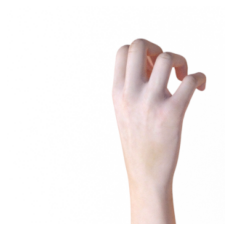

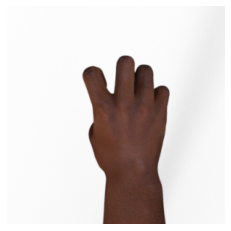

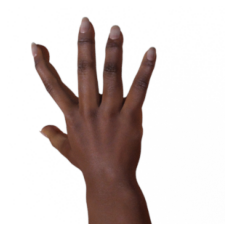

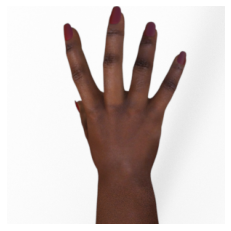

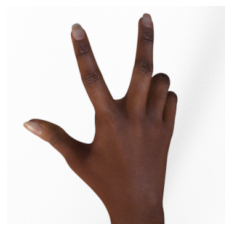

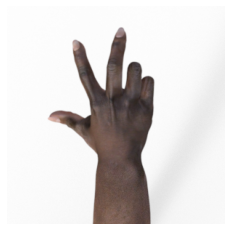

In [7]:
pic_index = 2

next_rock = [os.path.join(rock_dir, fname) for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

# Data Augmentation & Data Generator

In [8]:
TRAINING_DIR = "/tmp/rps/"
VALIDATION_DIR = "/tmp/rps-test-set/"

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       target_size=(150, 150),
                                                       class_mode='categorical',
                                                       batch_size=126)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              target_size=(150, 150),
                                                              class_mode='categorical',
                                                              batch_size=126)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


# Create & Train the Model

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss = 'categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [10]:
history = model.fit(train_generator, 
                    epochs=25, 
                    steps_per_epoch=20, 
                    validation_data = validation_generator, 
                    validation_steps=3)


Epoch 1/25
20/20 [==============================] - 57s 1s/step - loss: 1.2340 - accuracy: 0.3595 - val_loss: 1.0549 - val_accuracy: 0.6962
Epoch 2/25
20/20 [==============================] - 23s 1s/step - loss: 1.1010 - accuracy: 0.3976 - val_loss: 1.5877 - val_accuracy: 0.3333
Epoch 3/25
20/20 [==============================] - 23s 1s/step - loss: 1.1011 - accuracy: 0.4790 - val_loss: 0.9574 - val_accuracy: 0.5081
Epoch 4/25
20/20 [==============================] - 23s 1s/step - loss: 1.0064 - accuracy: 0.5512 - val_loss: 0.9017 - val_accuracy: 0.5914
Epoch 5/25
20/20 [==============================] - 24s 1s/step - loss: 0.9408 - accuracy: 0.5937 - val_loss: 0.4462 - val_accuracy: 0.7849
Epoch 6/25
20/20 [==============================] - 23s 1s/step - loss: 0.7604 - accuracy: 0.6790 - val_loss: 0.4286 - val_accuracy: 0.6882
Epoch 7/25
20/20 [==============================] - 23s 1s/step - loss: 0.6738 - accuracy: 0.6956 - val_loss: 0.2659 - val_accuracy: 0.9651
Epoch 8/25
20/20 [==

In [13]:
model.evaluate(validation_generator)

3/3 [==============================] - 1s 438ms/step - loss: 0.1253 - accuracy: 0.9570


[0.12531615793704987, 0.9569892287254333]

# Save the Model

In [11]:
model.save("rps.h5")

# Evaluate loss & accuracy

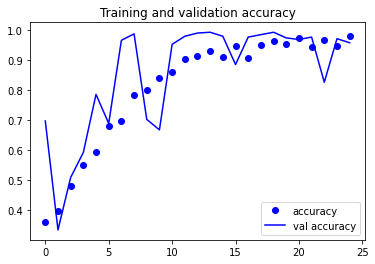

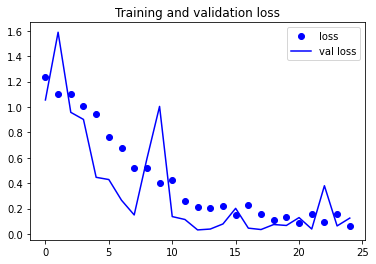

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc , 'bo', label='accuracy')
plt.plot  ( epochs, val_acc , 'b', label='val accuracy')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss , 'bo', label='loss')
plt.plot  ( epochs, val_loss , 'b', label='val loss')
plt.title ('Training and validation loss'   )
plt.legend()

# Test the Model

In [12]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)